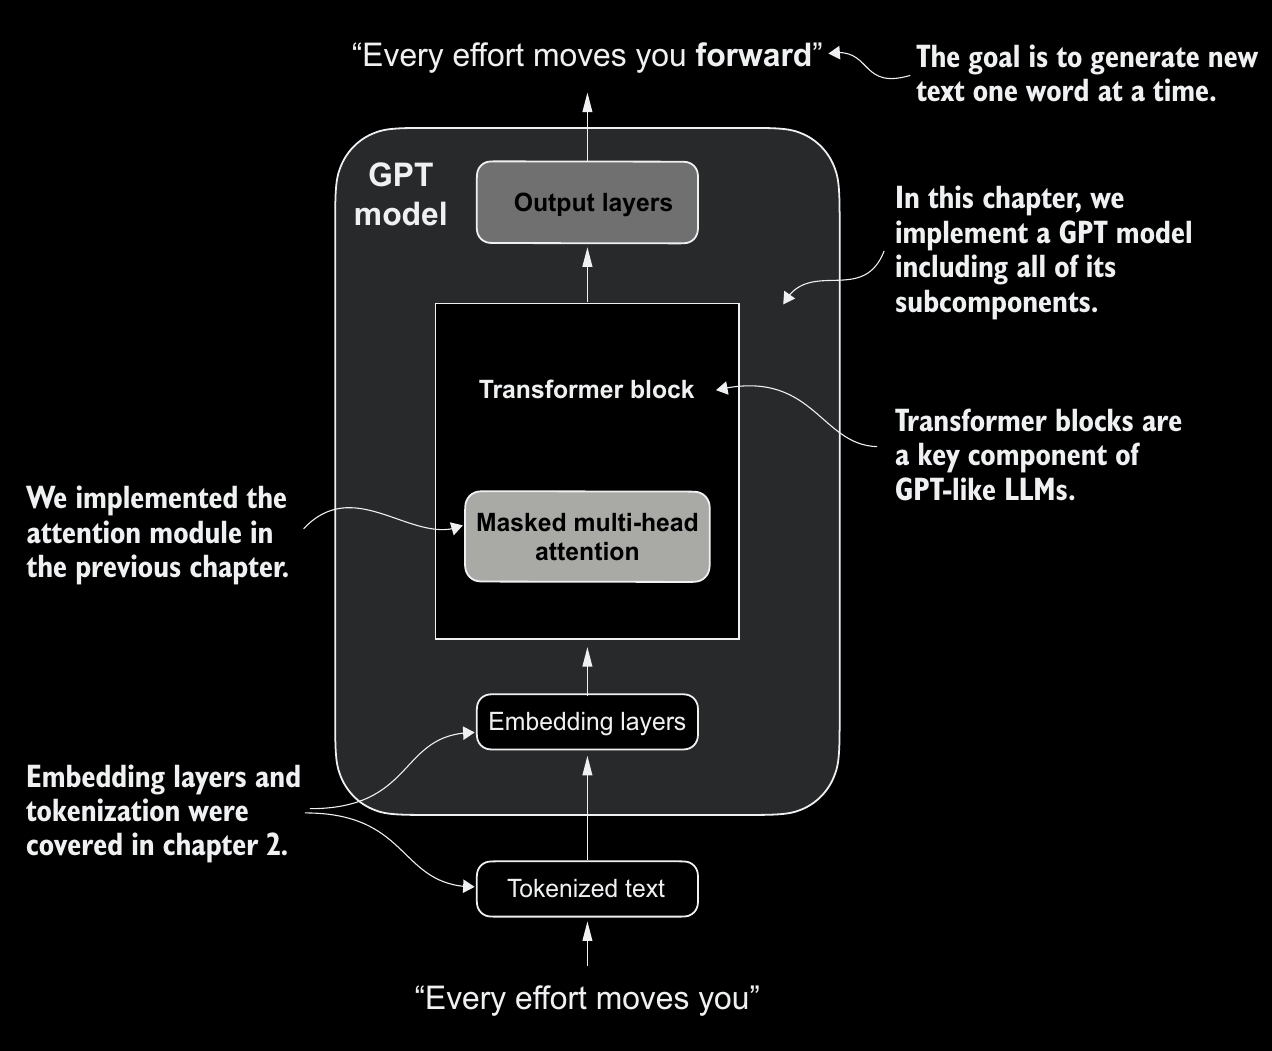

In [47]:
# Specifying the configuration of GPT-2 model we will be using
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "embed_dim": 768,       # Embedding dimensions
    "n_heads": 12,          # number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-key-value bias
}


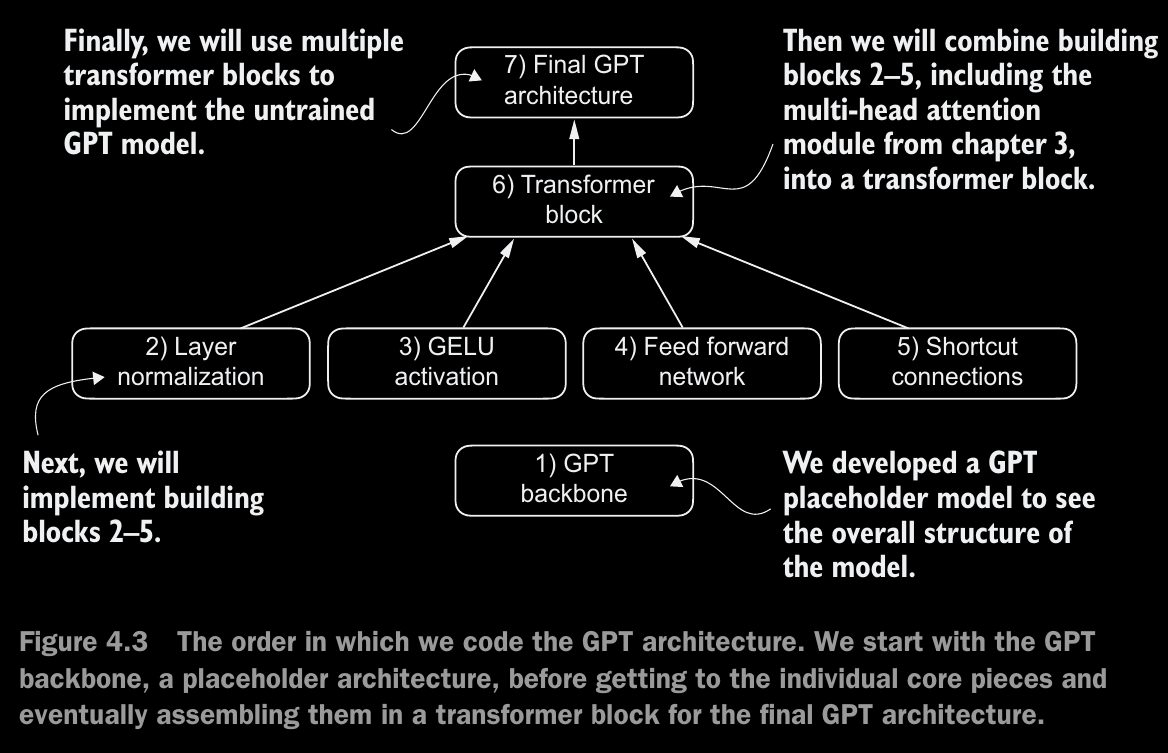

In [48]:
# A placeholder GPT model
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embed_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embed_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])
    # Using it as a place holder for TransformerBlock.
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg)
        for _ in range(cfg["n_layers"])]
    )
    self.final_norm = DummyLayerNorm(cfg["embed_dim"])
    self.out_head = nn.Linear(
        cfg["embed_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)
    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()

  def forward(self,x):
    return x

class DummyLayerNorm(nn.Module):
  def __init__(self,normalized_shape, eps = 1e-5):
    super().__init__()

  def forward(self,x):
    return x

## Implementing a tokenizer

In [49]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


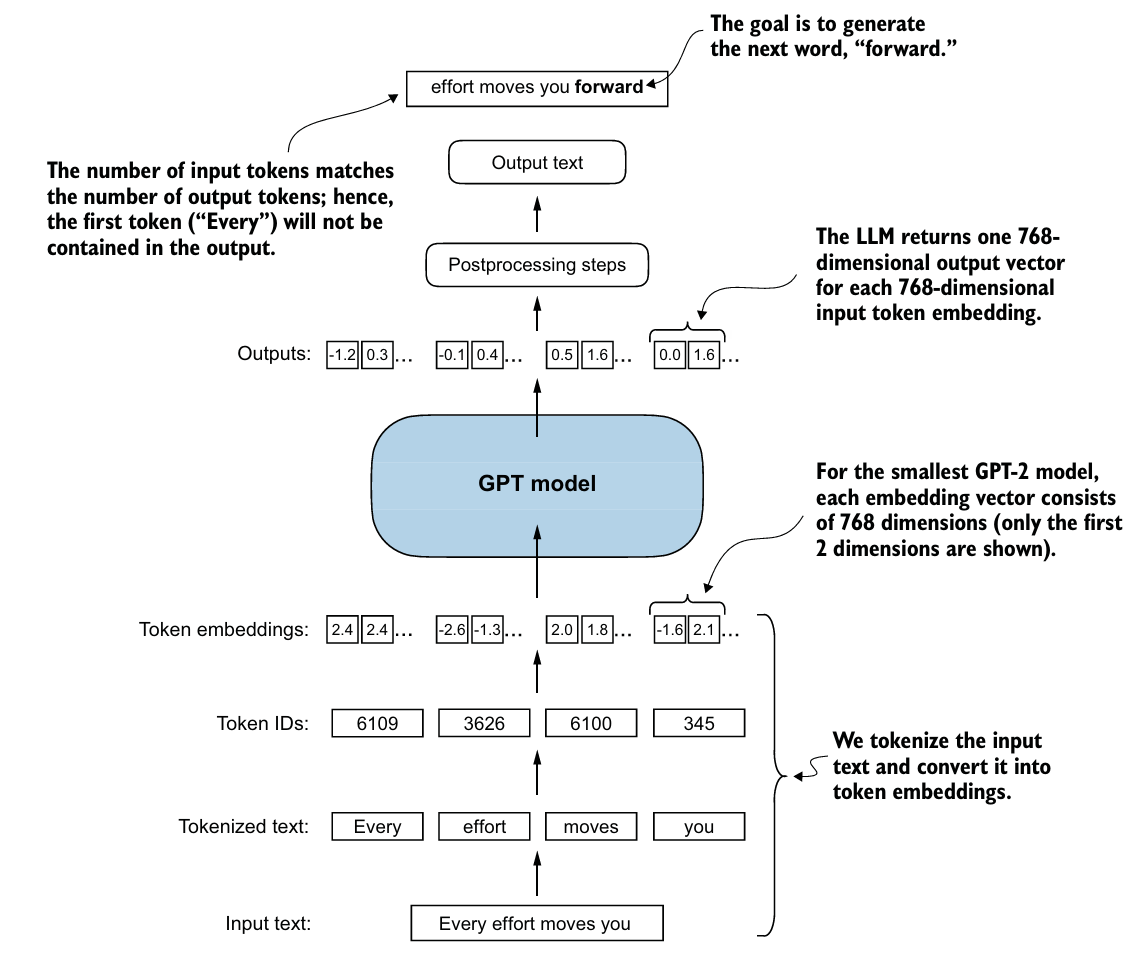

Now we initialize 124-million-parameter DummyGPTModel

In [50]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:",logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


 The output tensor has two rows corresponding to the two text samples. Each text sam
ple consists of four tokens; each token is a 50,257-dimensional vector, which matches
 the size of the tokenizer’s vocabulary.
 The embedding has 50,257 dimensions because each of these dimensions refers to
 a unique token in the vocabulary. When we implement the postprocessing code, we
 will convert these 50,257-dimensional vectors back into token IDs, which we can then
 decode into words.

---
**Normalizing Activations with layer normalization:**

Layer normalization is used to improve the stability and effeciency of neural netwerok training. The main idea behind normalization is to adjust the outputs of a neural network layer to have a mean of 0 and a variation of 1. This adjustment speeds up the convergence of effective weights and ensures consistent, reliable trainig.

In modern transformer layer normalization is typically applied before and after the multi-head attention module



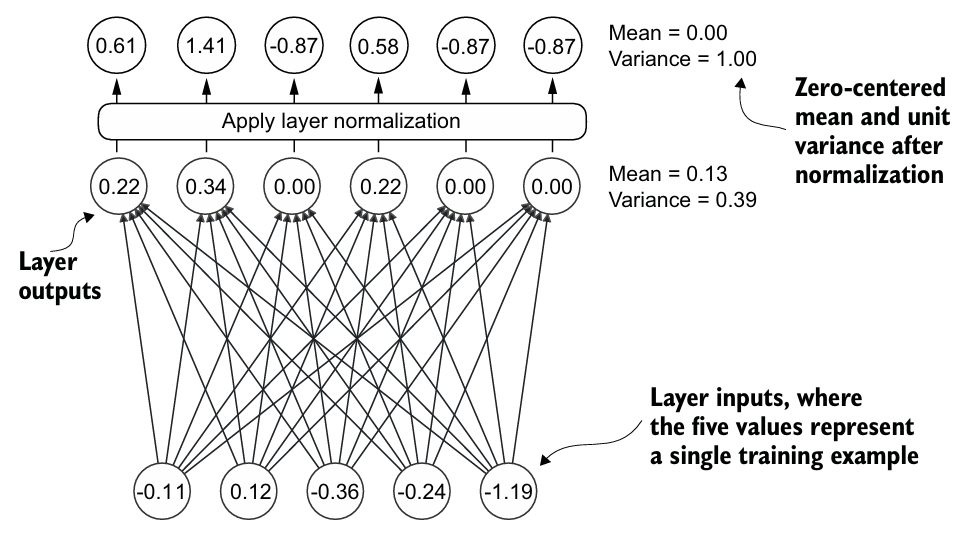

In [51]:
# Recreating the above image
torch.manual_seed(123)
batch_example = torch.randn(2,5)
layer = nn.Sequential(nn.Linear(5,6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [52]:
# Before applying layer normalization
mean1 = out.mean(dim = -1, keepdim = True)
var1 = out.var(dim = -1, keepdim = True)
print("Mean:\n", mean1)
print("Variance:\n", var1)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


The first row contains the mean, variance of first input vector and second row contains mean, var of second input row

In [53]:
# Applying layer normalization
out_norm = (out-mean1)/torch.sqrt(var1)
mean = out_norm.mean(dim = -1, keepdim = True)
var = out_norm.var(dim = -1, keepdim = True)
print("Normalized layer outputs:\n",out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [1.9868e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


## Coding layer Normalization

In [54]:
class LayerNorm(nn.Module):
  def __init__(self,embed_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(embed_dim))
    self.shift = nn.Parameter(torch.zeros(embed_dim))

  def forward(self,x):
    mean = x.mean(dim = -1, keepdim = True)
    var = x.var(dim = -1, keepdim = True, unbiased = False)
    norm_x = (x-mean)/torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

The `scale` and `shift` are two trainable parameters that the LLM automatically adjusts during training if it determined that doing so would improve model performance on its training tasks. This allows model to learn appropraite scaling and shifting that best suites its data processing.

In [55]:
# Applying the module `LayerNorm` to practice
ln = LayerNorm(embed_dim = 5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim = -1, keepdim = True)
var = out_ln.var(dim = -1, unbiased = False, keepdim = True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-2.9802e-08],
        [ 0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### An implementation of GELU() activation function


In [56]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1+torch.tanh(
        torch.sqrt(torch.tensor(2.0/torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

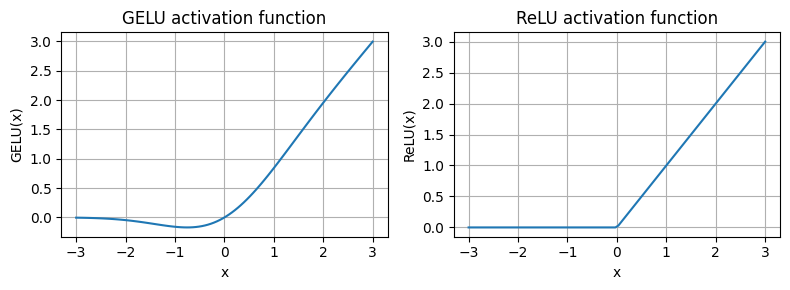

In [57]:
# Visualizing GELU() activation funuction
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize = (8,3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu],["GELU","ReLU"]),1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()

The smoothness of GELU can lead to a better optimization properties during training as it allows for more nuances adjustments to the model's parameters

### Feed-Forward network

In [58]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["embed_dim"], 4*cfg["embed_dim"]),
        nn.GELU(),
        nn.Linear(4 * cfg["embed_dim"], cfg["embed_dim"])
    )
  def forward(self,x):
    return self.layers(x)

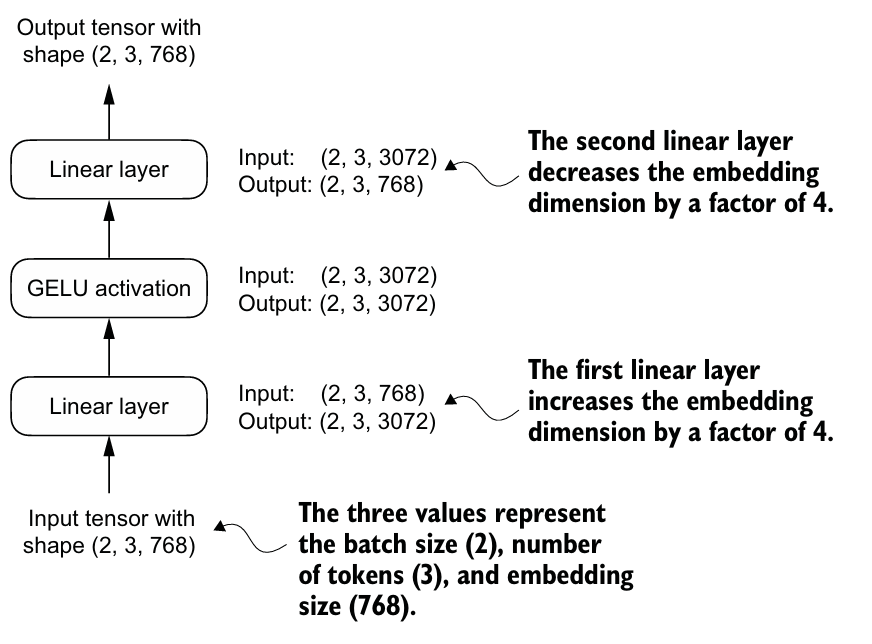

The FeedForward module plays a crucial role in enhancing the model's ability to learn form and generalize the data. Although the input and output dimensions of this module are the same, it internally expands expands the embedding dimensions into higher dimensional space through first linear layer.


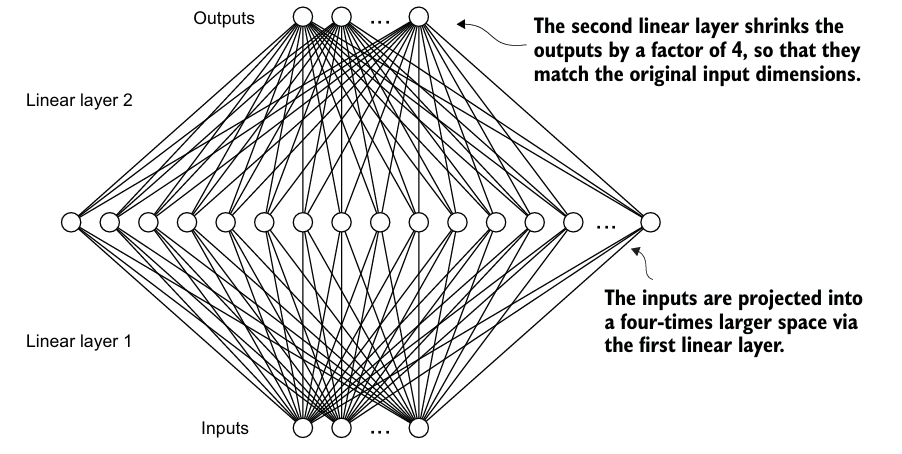

This expansion is followed by a nonlinear GELU() activation and then a contraction back to the original dimension with second linear transformation. Such a design allows for the exploration of a richer space.

### Skip connections

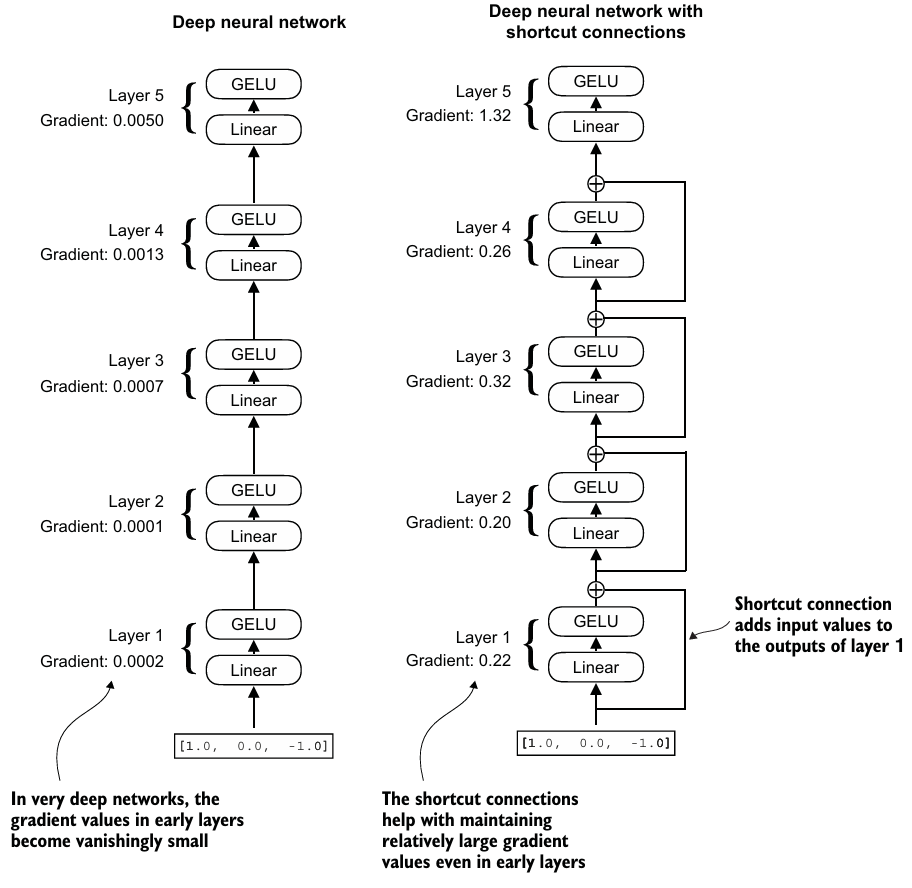

Shortcut connections create an alternate, shorter path for the gradient to flow through the network by skipping one or more layers, which is achieved by adding the output of one layer to the output of a later layer.

In [59]:
# Example to illustrate skip connections
class ExampleDeepNeuralNetwork(nn.Module):
  def __init__(self, layer_size, use_shortcut):
    super().__init__()
    self.use_shortcut = use_shortcut
    self.layers = nn.ModuleList([
        nn.Sequential(nn.Linear(layer_size[0], layer_size[1]),
        nn.GELU()),
        nn.Sequential(nn.Linear(layer_size[1], layer_size[2]),
        nn.GELU()),
        nn.Sequential(nn.Linear(layer_size[2], layer_size[3]),
        nn.GELU()),
        nn.Sequential(nn.Linear(layer_size[3], layer_size[4]),
        nn.GELU()),
        nn.Sequential(nn.Linear(layer_size[4], layer_size[5]),
        nn.GELU())
    ])

  def forward(self, x):
    for layer in self.layers:
      layer_output = layer(x) # Compute the output of current layer
      if self.use_shortcut and x.shape ==layer_output.shape: # Check if shortcut can be applied
        x = x + layer_output
      else:
        x = layer_output
    return x

In [60]:
# Testing
layer_size = [3,3,3,3,3,1]
sample_input = torch.tensor([[1.,0.,-1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_size, use_shortcut = False
)

In [61]:
# A function to compute the gradient in the model's backward pass
def print_gradient(model,x):
  output = model(x)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output,target)

  loss.backward()

  for name, param in model.named_parameters():
    if 'weight' in name:
      print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")


In [62]:
print_gradient(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020174118981231004
layers.1.0.weight has gradient mean of 0.00012011769285891205
layers.2.0.weight has gradient mean of 0.0007152436301112175
layers.3.0.weight has gradient mean of 0.00139885104727
layers.4.0.weight has gradient mean of 0.005049602594226599


In [63]:
# Lets now try a model with skip connections
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_size, use_shortcut = True
)
print_gradient(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22186800837516785
layers.1.0.weight has gradient mean of 0.20709273219108582
layers.2.0.weight has gradient mean of 0.3292388319969177
layers.3.0.weight has gradient mean of 0.2667772173881531
layers.4.0.weight has gradient mean of 1.3268063068389893


### Connecting attention mechanism and skip connection

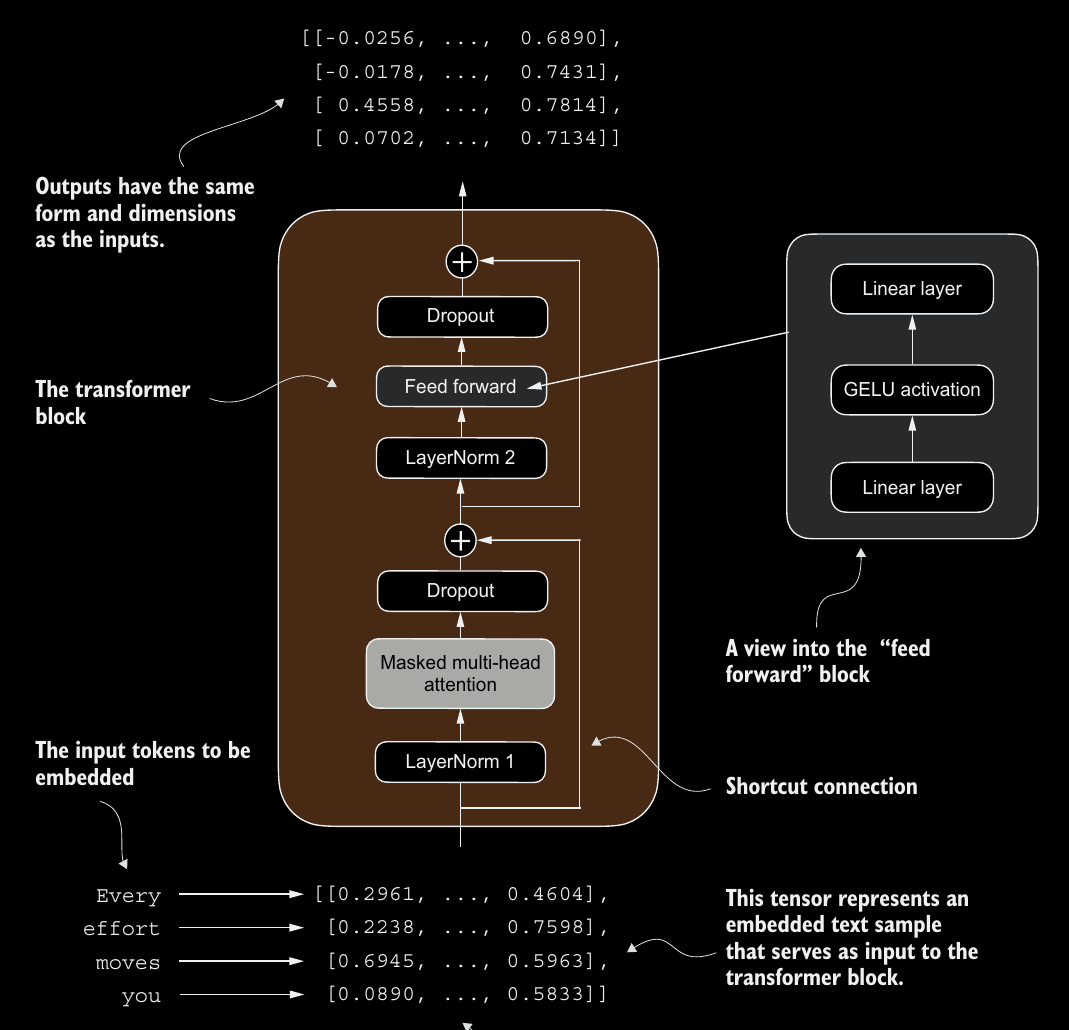

The idea is that the self-attention mechanism in the multi-head attention block iden-
tifies and analyzes relationships between elements in the input sequence. In contrast,
the feed forward network modifies the data individually at each position. This combina-
tion not only enables a more nuanced understanding and processing of the input but
also enhances the model’s overall capacity for handling complex data patterns.

In [64]:
! pip install import_ipynb

In [65]:
import import_ipynb
from Coding_attention_mechanism import MultiHeadAttention

In [66]:
# Copied directly from Coding_attention_mechanism.ipynb for ease
class MultiHeadAttention1(nn.Module):
  def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias = False):
    super().__init__()
    assert (d_out % num_heads ==0), \
    "d_out must be divisible by num_heads"

    self.d_out = d_out
    self.num_heads = num_heads
    self.head_dim = d_out // num_heads # Reduces the projection dim to match the desired output
    self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
    self.out_proj = nn.Linear(d_out, d_out) # Uses a linear layer to combine the head outputs
    self.dropout = nn.Dropout(dropout)
    self.register_buffer(
        "mask",
        torch.triu(torch.ones(context_length, context_length),
                   diagonal = 1)
    )

  def forward(self,x):
    b, num_tokens, d_in = x.shape # Tensor shape: (b, num_tokens, d_out)
    keys = self.W_key(x)
    queries = self.W_query(x)
    values = self.W_value(x)

    keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) # This function returns the same tensor but with a different shape
    values = values.view(b, num_tokens, self.num_heads, self.head_dim) # The matrix is being explicitly split here by adding a num_heads dim
    queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

    keys = keys.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)
    queries = queries.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)
    values = values.transpose(1,2) # (b, num_token, num_heads, head_dim) --> (b, num_heads, num_tokens, head_dim)

    attn_scores = queries @ keys.transpose(2,3)
    mask_bool = self.mask.bool()[:num_tokens, :num_tokens] # Masks truncated to the number of tokens

    attn_scores.masked_fill_(mask_bool, -torch.inf) # Uses masks to fill attention scores

    attn_weights = torch.softmax(
        attn_scores/keys.shape[-1]**0.5, dim = -1)
    attn_weights = self.dropout(attn_weights)

    context_vec = (attn_weights @ values).transpose(1,2) # (b, num_tokens, n_heads, head_dim) essential

    # Combines heads, where self.d_out = self.num_heads*self.head_dim
    context_vec = context_vec.contiguous().view(
        b, num_tokens, self.d_out
        )
    context_vec = self.out_proj(context_vec) # Adds an optional linear projection
    return context_vec

In [67]:
# Creating transformer block in code

class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att = MultiHeadAttention1(d_in = cfg["embed_dim"],
                                   d_out = cfg["embed_dim"],
                                   context_length = cfg["context_length"],
                                   num_heads = cfg["n_heads"],
                                   dropout = cfg["drop_rate"],
                                   qkv_bias = cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["embed_dim"])
    self.norm2 = LayerNorm(cfg["embed_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):

    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x+shortcut # Adding the original input back

    shortcut = x  # Shortcut connection for the feed forward connection
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut  # Adds the original input back
    return x


### GPT-model implementation

In [68]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["embed_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["embed_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )

    self.final_norm = LayerNorm(cfg["embed_dim"])
    self.out_head = nn.Linear(
        cfg["embed_dim"], cfg["vocab_size"], bias = False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(
        torch.arange(seq_len, device = in_idx.device)
    )
    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits

In [69]:
# Initializing the 124M parameter GPT-2 model
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0712,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1793, -0.5660, -0.9486,  ...,  0.0477,  0.5181, -0.3169],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1017, -0.4326, -0.2553],
         [-1.0076,  0.3419, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2565,  0.0901,  0.0335,  ...,  0.2658,  0.4454, -0.6806],
         [ 0.1229,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2245],
         [ 1.0558,  1.0318, -0.2799,  ...,  0.6935,  0.3205, -0.3178],
         [-0.1567,  0.3928,  0.3288,  ...,  1.2630, -0.1859,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


Lets Analyze the model architecture using the numel() method

In [73]:
total_parameters = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_parameters:,}")

Total number of parameters: 163,009,536


Since we were going to create a model with 124M parameters but instead we got one with 163M parameters. The reason being the concept of weight lying was used in GPT-2 architecture which reuses weights from the token embeddings in the output layer.

In [71]:
# For better understanding we will take a look at token embedding layer and linear output layer
print("Token embedding layer: ", model.tok_emb.weight.shape)
print("Output layer shape: ", model.out_head.weight.shape)

Token embedding layer:  torch.Size([50257, 768])
Output layer shape:  torch.Size([50257, 768])


In [74]:
total_params_gpt2 = (
    total_parameters - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


In [86]:
total_size_bytes = total_parameters * 4
total_size_mb = total_size_bytes/(1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


### Generating Text

We will now be converting the output of the GPT model into text.

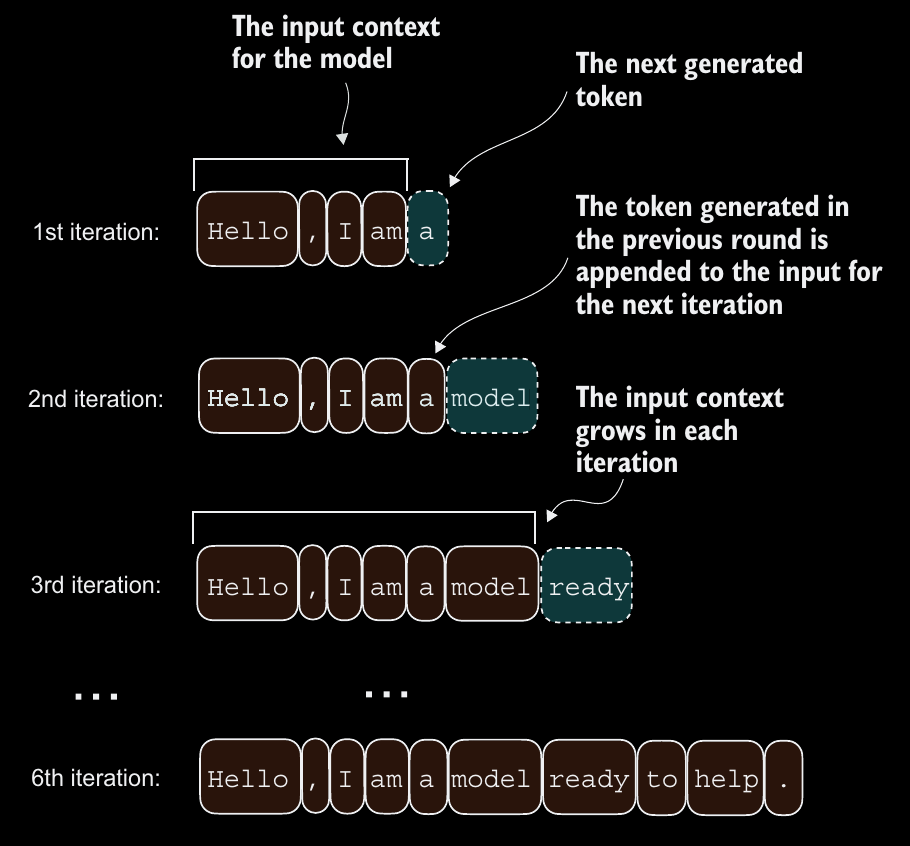

The process of geneating text step by step includes decoding the output tensors, selecting tokens based on a probability distributions, and converting these tokens into human readable text.

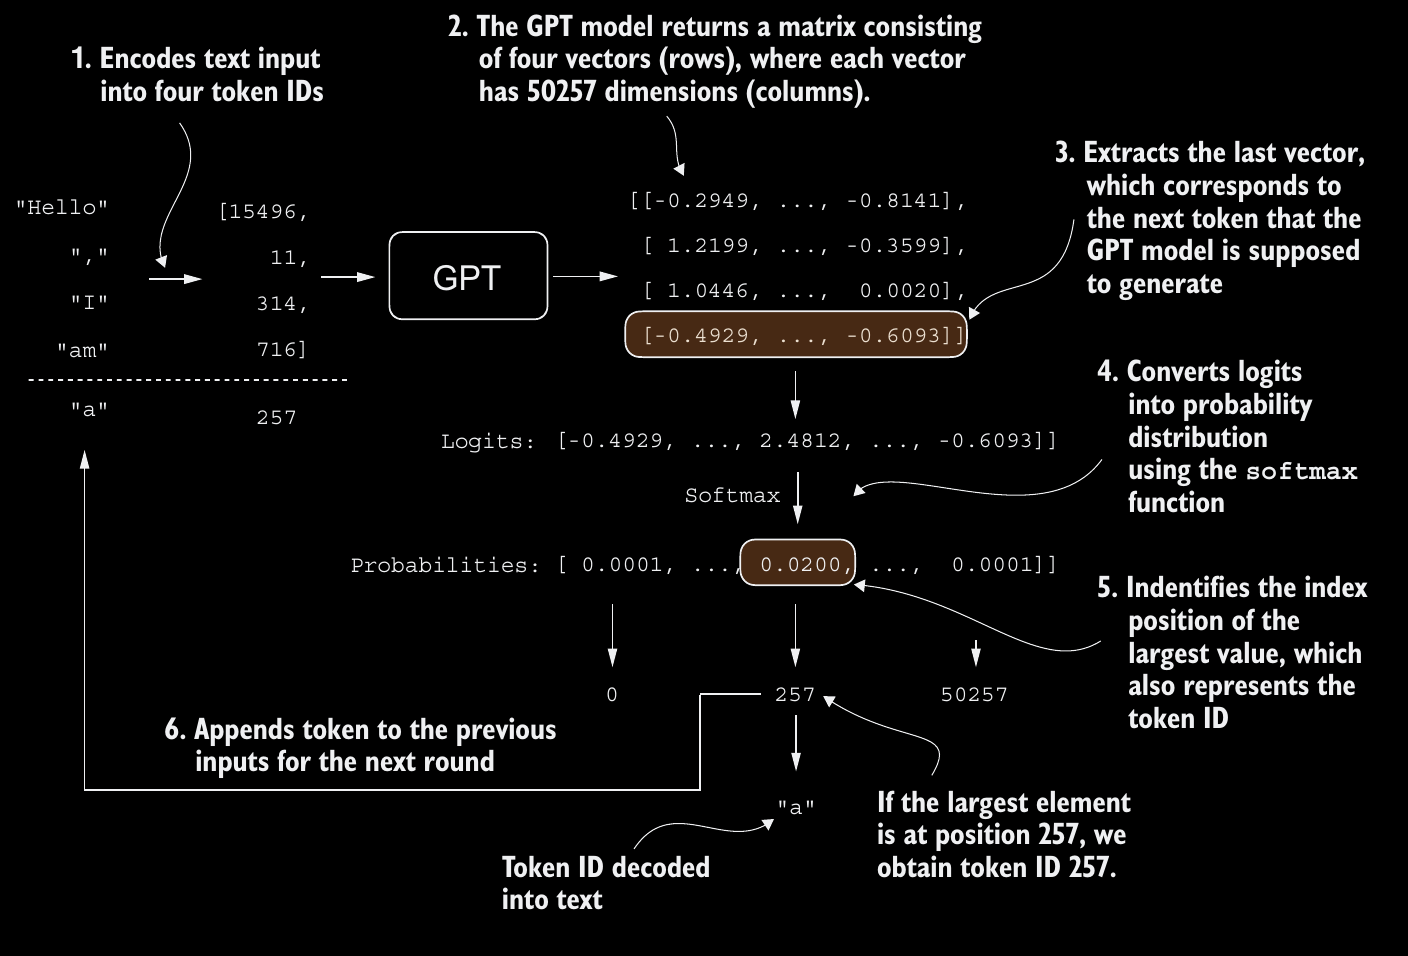

In each step the model outputs a matrix with vectors representing potential next tokens. The vectors corresponding to the next tokens is extracted and converted into a probability distribution via `softmax` function. Within the vector containing the resulting probability probability score, the index of highest value is located, which translates into token ID. This token ID is then decoded back into text, producing the next token in sequence

In [104]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:] # Crops the current context if it exceeds the supported context size,
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim = -1)
    idx_next = torch.argmax(probas, dim = -1, keepdim = True)
    idx = torch.cat((idx, idx_next), dim = 1)

  return idx

In [105]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


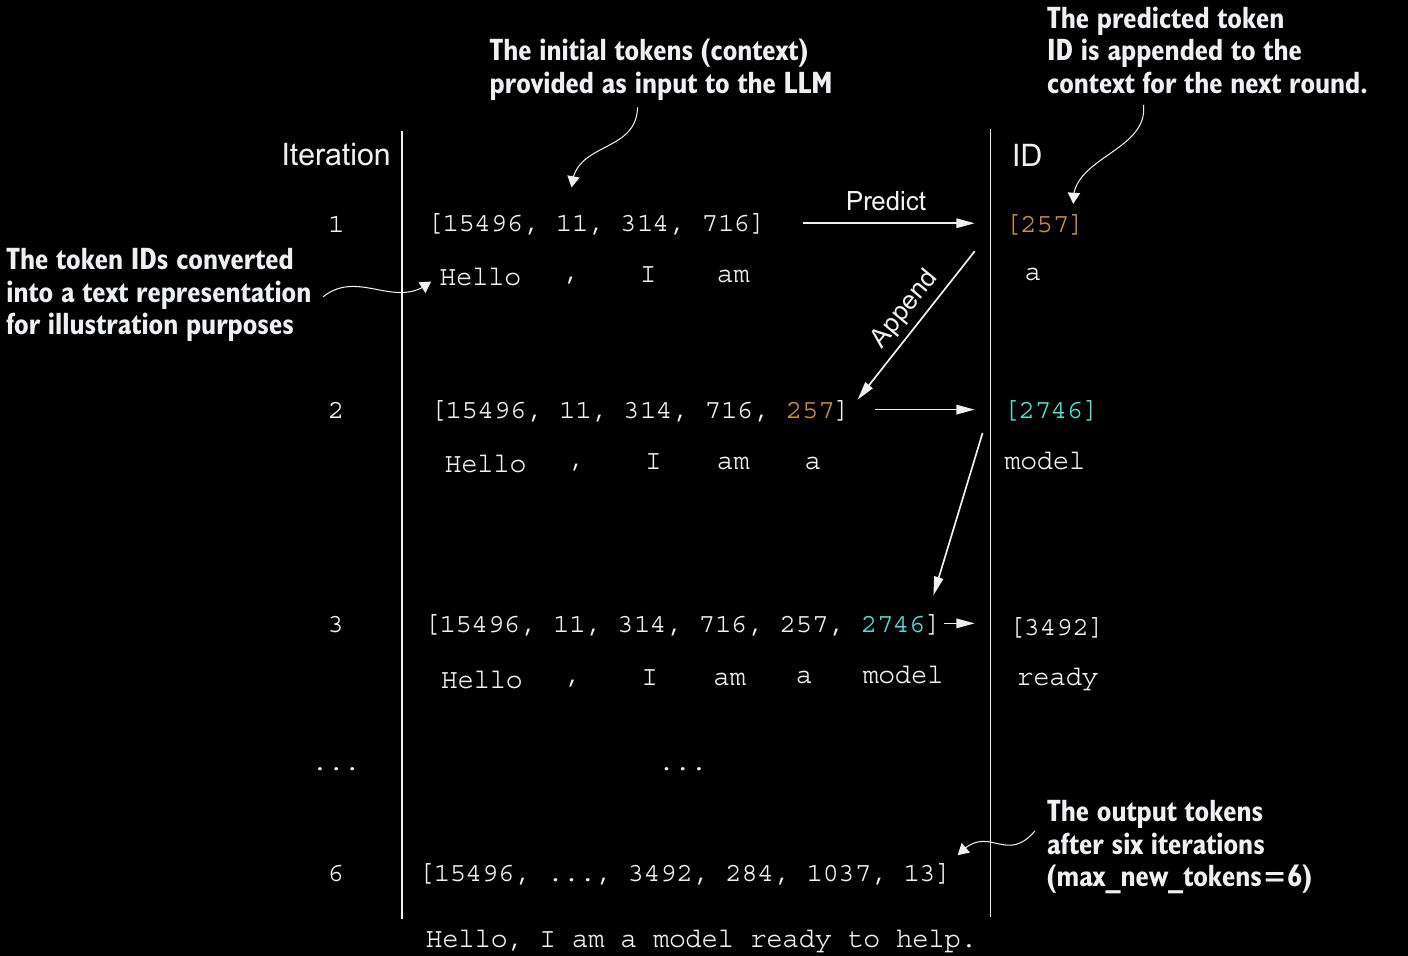

In [111]:
model.eval()
out = generate_text_simple(
    model = model,
    idx = encoded_tensor,
    max_new_tokens = 20,
    context_size = GPT_CONFIG_124M["context_length"]
)
print("Output: ", out)
print("Output length: ", len(out[0]))

Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267,
         49706, 43231, 47062, 34657, 18631, 49188, 43312, 45933, 23154, 15983,
         10345, 16369, 46214, 22954]])
Output length:  24


In [112]:
decode_text = tokenizer.decode(out.squeeze(0).tolist())
print(decode_text)

Hello, I am Featureiman Byeswickattribute argue logger Normandy Compton analogous bore ITVEGIN ministriesysics Kle functional recountrictionchanging
